## CS310 Natural Language Processing
## Lab 6: LSTM for Named Entity Recognition (NER)

In this lab, we practice the data and model preparation for using LSTM for the NER task. 

The dataset is CoNLL2003 English named entity recognition (NER). The dataset is a collection of news articles from Reuters. 

The dataset is annotated with four types of named entities: 
`[persons, locations, organizations, miscellaneous]`. (`miscellaneous` does not belong to the previous three types)

The dataset is divided into three parts: **training**, **development**, and **testing**. 


In [2]:
from pprint import pprint
import torch.nn as nn
import torch.nn.functional as F
import torch

from utils import Indexer, read_ner_data_from_connl, get_batch

In [3]:
TRAIN_PATH = 'data/train.txt'
DEV_PATH = 'data/dev.txt'
TEST_PATH = 'data/test.txt'
EMBEDDINGS_PATH = 'data/glove.6B.100d.txt' 
# Download from https://nlp.stanford.edu/data/glove.6B.zip
# It includes dimension 50, 100, 200, and 300.

The dataset is in the IOB format. 
The IOB format is a simple text chunking format that divides the text into chunks and assigns a label to each chunk. 
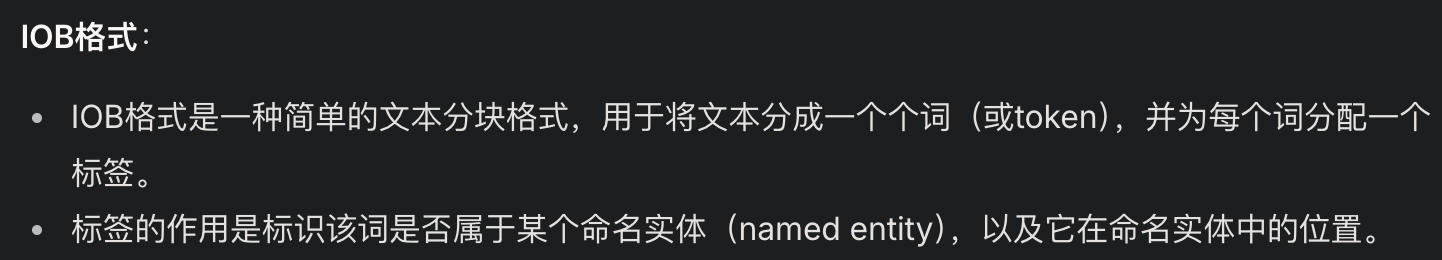
The label is a combination of two parts: 
- the type of the named entity
- the position of the word in the named entity. 

The type of the named entity is one of the four types `[persons, locations, organizations, miscellaneous]`. 

The position of the word in the named entity is one of three positions: `B` (beginning), `I` (inside), and `O` (outside). 
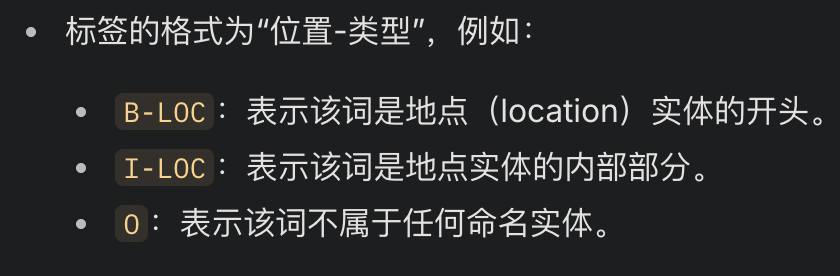
Examples:
- "New" in the named entity "New York" is labeled as "B-LOC", and "York" is labeled as "I-LOC". 
- The word "I" in the sentence "I live in New York" is labeled as "O".

In [4]:
train_words, train_tags = read_ner_data_from_connl(TRAIN_PATH)
dev_words, dev_tags = read_ner_data_from_connl(DEV_PATH)
test_words, test_tags = read_ner_data_from_connl(TEST_PATH)

In [5]:
print('train words size:', len(train_words))
print('dev words size:', len(dev_words))
print('test words size:', len(test_words))

train words size: 203621
dev words size: 51362
test words size: 46435


In [6]:
print(train_words[:10])
print(train_tags[:10])

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.', 'Peter']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'B-PER']


In [7]:
pprint(list(zip(train_words[:10], train_tags[:10])))

[('EU', 'B-ORG'),
 ('rejects', 'O'),
 ('German', 'B-MISC'),
 ('call', 'O'),
 ('to', 'O'),
 ('boycott', 'O'),
 ('British', 'B-MISC'),
 ('lamb', 'O'),
 ('.', 'O'),
 ('Peter', 'B-PER')]


**Note** that each sentence ends with token '.' and tag 'O'. Between sentences there is a blank line.

---

## T1. Build vocabularies for both words and tags


`utils.py` provides an `Indexer` class that can be used to convert words and tags to indices and vice versa.

In [8]:
indexer_train_words = Indexer(train_words)
indexer_train_tags = Indexer(train_tags)

# Test
print('index of word "the":', indexer_train_words.element_to_index('the'))
print('index of tag "O":', indexer_train_tags.element_to_index('O'))
print('word with index 0:', indexer_train_words.index_to_element(0))
print('word with index 100', indexer_train_words.index_to_element(100))
print('tag with index 0:', indexer_train_tags.index_to_element(0))
print('tag with index 1:', indexer_train_tags.index_to_element(1))

index of word "the": 40
index of tag "O": 2
word with index 0: <UNKNOWN>
word with index 100 Fischler
tag with index 0: <UNKNOWN>
tag with index 1: B-ORG


However, since the train, test, and dev sets are different, we need to build the vocabularies using **ALL** the data.

In [9]:
### START YOUR CODE ###
indexer_words = Indexer(train_words + dev_words + test_words)
indexer_tags = Indexer(train_tags + dev_tags + test_tags)
### END YOUR CODE ###

# Test
print('sizes of indexers from all data:')
print(len(indexer_words), len(indexer_tags))

# You are expected to see the following output:
# sizes of indexers from all data:
# 30290 10

sizes of indexers from all data:
30290 10


## T2. Prepare data in batch

What it means by a "batch" of data is different from Lab 5 (Language Modeling).

Because the sequence boundaries are some-what difficult to determine, and the sequences are of varying lengths, for this NER lab, we use a sloppy way to create batches: Simply use a fixed size (`batch_size`) of tokens as a batch. So there is just one long sequence in each batch.

`utils.py` provides a `get_batch` function that yields `(words, tags)` in specified batch size.

In [10]:
batch_size = 128 # batch是指一次训练或推理中处理的一组数据
batches = list(get_batch(train_words, train_tags, batch_size)) # 采用一种“sloppy”（简陋的）方式创建batch;不按句子或序列边界划分，而是直接将数据视为一个长序列,然后按照batch_size划分

# Test
print('batches[0] sizes:', len(batches[0][0]), len(batches[0][1])) 
print('batches[1] sizes:', len(batches[1][0]), len(batches[1][1]))

batches[0] sizes: 128 128
batches[1] sizes: 128 128


Use `Indexer.elements_to_indices` to convert words and tags to indices.

In [11]:
sequence, tags = batches[0]

### START YOUR CODE ###
sequence_ids = Indexer.elements_to_indices(indexer_words, sequence)
tags_ids = Indexer.elements_to_indices(indexer_tags, tags)
### END YOUR CODE ###

# Test
print('sequence_ids[:10]', sequence_ids[:10])
print('tags_ids[:10]', tags_ids[:10])

# You are expected to see the following output:
# sequence_ids[:10] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# tags_ids[:10] [1, 2, 3, 2, 2, 2, 3, 2, 2, 4]

sequence_ids[:10] [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
tags_ids[:10] [1, 2, 3, 2, 2, 2, 3, 2, 2, 4]


## T3. Practice LSTM module

Create a LSTM unit that takes input of dimension 3 and produces hidden state of dimension 4.

In [12]:
lstm = nn.LSTM(3, 4)# 每个时间步的输入向量有3个元素,隐藏状态有4个元素

# Make a sequence of length 5
input_seq = [torch.randn(1, 3) for _ in range(5)]# 创建一个长度为5的序列，每个时间步的输入向量有3个元素
# 包含5个形状为 (1, 3) 的张量

# Initialize hidden state and cell state
h0 = torch.randn(1, 4)
c0 = torch.randn(1, 4) # 隐藏状态和细胞状态的维度都是4
hidden = (h0, c0)

# Run forward pass with a loop
for input_t in input_seq:
    out, hidden = lstm(input_t, hidden) # Note that the hidden state from the previous time step is used as input for the current time step
# out是最后一个时间步的隐藏状态

# Test output
print('output size:', out.size())
print('hidden hn size:', hidden[0].size())
print('hidden cn size:', hidden[1].size())
print(torch.equal(out, hidden[0])) # out is just the last hidden state hn

output size: torch.Size([1, 4])
hidden hn size: torch.Size([1, 4])
hidden cn size: torch.Size([1, 4])
True


The same forward pass can be done with a single call to `lstm`, providing the entire sequence at once.

In [13]:
# Make a sequence of length 5 in a single tensor
input_seq2 = torch.cat(input_seq, dim=0)
# 将 input_seq 中的张量沿着第0维（dim=0）拼接起来，形成一个形状为 (5, 1, 3) 的张量

# Initialize hidden state and cell state
h0 = torch.randn(1, 4)
c0 = torch.randn(1, 4)
hidden = (h0, c0)

# Run forward pass with a single call
out, hidden = lstm(input_seq2, hidden)# out 包含所有时间步的隐藏状态

# Test output
print('output size:', out.size())
print('hidden hn size:', hidden[0].size())
print('hidden cn size:', hidden[1].size())

print(torch.equal(out, hidden[0])) # this time out != hn

output size: torch.Size([5, 4])
hidden hn size: torch.Size([1, 4])
hidden cn size: torch.Size([1, 4])
False


Note that this time `out` is a sequence of hidden states for all times steps, not just the last one.

What about a bi-directional LSTM?

In [14]:
bilstm = nn.LSTM(3, 4, bidirectional=True)

# Initialize hidden state and cell state
h0 = torch.randn(2, 4) # 双向LSTM，所以隐藏状态的维度是2
c0 = torch.randn(2, 4)
hidden = (h0, c0)

# Forward pass
out, hidden = bilstm(input_seq2, hidden)

# Test output
print('output size:', out.size())
print('hidden hn size:', hidden[0].size())
print('hidden cn size:', hidden[1].size())

output size: torch.Size([5, 8])
hidden hn size: torch.Size([2, 4])
hidden cn size: torch.Size([2, 4])


Note that the output size becomes $2\times4=8$ because the LSTM is bidirectional.

## T4. Using LSTM for tagging

Here we practice using LSTM for tagging tasks (e.g., POS, NER). 
We will not use advanced architecture like maximum entropy Markov model (MEMM), or advanced decoding strategies such as Viterbi, or beam search decoding.

The model is as follows: let the input sentence be
$w_1, \dots, w_M$, where $w_i \in V$, our vocab. Also, let
$T$ be our tag set, and $y_i$ the tag of word $w_i$.


Denote our prediction of the tag of word $w_i$ by
$\hat{y}_i$.
This is a structure prediction, model, where our output is a sequence
$\hat{y}_1, \dots, \hat{y}_M$, where $\hat{y}_i \in T$.

To do the prediction, pass an LSTM over the sentence. Denote the hidden
state at timestep $i$ as $h_i$. Also, assign each tag a
unique index. 

Then our prediction rule for $\hat{y}_i$ is

\begin{align}\hat{y}_i = \text{argmax}_j \  (\log \text{Softmax}(U h_i + b))_j\end{align}

That is, take the log softmax of the transformation of the hidden state $h_i$,
and the predicted tag is the tag that has the maximum log probability. 
对隐藏状态hi进行线性变换后，计算其对数softmax值，预测标签是具有最大对数概率的标签。
Parameters $U$ and $b$ can be implemented as a linear layer.

In [15]:
EMBEDDING_DIM = 6
HIDDEN_DIM = 6
VOCAB_SIZE = len(indexer_words)
TAGSET_SIZE = len(indexer_tags)

input_sequence = train_words[:9]
input_tags = train_tags[:9]

print('input_sequence:', input_sequence)
print('input_tags:', input_tags)

input_sequence: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
input_tags: ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


Next, create the model.

In `__init__` method, initialize `word_embeddings` with a pretrained embedding weight matrix loaded from `glove.6B.100d.txt`.

For some advanced variants of model, e.g., maximum entropy Markov model (MEMM), you also need to initialize `tag_embeddings` with a random weight matrix.

`forward` method takes the sequence of word indices as input and returns the log probabilities of predicted tags. 

In [16]:
class LSTMTagger(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        ### START YOUR CODE ###
        self.word_embeddings = nn.Embedding(vocab_size,embedding_dim) # nn.Embedding
        self.lstm = nn.LSTM(embedding_dim,hidden_dim,batch_first=False) # Define LSTM
        self.fc = nn.Linear(hidden_dim,tagset_size) # Define linear layer
        ### END YOUR CODE ###

    def forward(self, sequence):
        ### START YOUR CODE ###
        embeds = self.word_embeddings(sequence) # Embed input sequence
        lstm_out, _ = self.lstm(embeds.unsqueeze(1)) # LSTM forward pass, return hidden state
        lstm_out = lstm_out.squeeze(1)
        logits = self.fc(lstm_out) # Linear layer forward pass, return logits
        logprobs = F.log_softmax(logits, dim=1) # Log softmax
        ### END YOUR CODE ###
        return logprobs

Initialize the model and test the forward computation.

In [17]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)

with torch.no_grad():
    ### START YOUR CODE ###
    sequence_ids = indexer_words.elements_to_indices(input_sequence)  # 将单词转换为索引
    inputs_tensor = torch.tensor(sequence_ids, dtype=torch.long)  # 转换为张量，形状 [9]
    logprobs = model(inputs_tensor)  # 获取 log 概率，形状 [9, 10]
    ### END YOUR CODE ###

# Test output
print('logprobs shape:', logprobs.shape)
# You are expected to see the following:
# logprobs shape: torch.Size([9, 10])

logprobs shape: torch.Size([9, 10])


## T5. Evaluation

Evaluation on multiple metrics are needed. Here we practice using the provided `metrices.py` file as a helper. 

In `metrices.py` there is a `MetricsHandler` class, which has an `update` method that should be called for every batch during training. 
It also has a `collect` method that should be called after each epoch.  

It takes a list of classes (target tags) as input, so we need to specify this arguement properly with the `indexer_tags` object or `TAGSET_SIZE`. 

In [18]:
from metrics import MetricsHandler

train_metrics = MetricsHandler(classes=list(range(TAGSET_SIZE)))
val_metrics = MetricsHandler(classes=list(range(TAGSET_SIZE)))

Here is an sample segment of training and evaluate code.

In [19]:
num_epochs = 5

def train_loop():
    """
    Training loop
    """
    for epoch in range(num_epochs):
        for sequence, tags in batches:
            # make prediction
            predictions = model(sequence)
            train_metrics.update(predictions, tags) # update() method takes the predictions and the ground truth tags as inputs

        train_metrics.collect()

        # print training metrics
        for metric in train_metrics.metrics_dict.keys():
                print(f"{metric} - {train_metrics.metrics_dict[metric][-1]}")
        print()

def evaluate_loop():
    """
    Evaluation loop
    """
    val_batches = get_batch(dev_words, dev_tags)
    for sequence, tags in val_batches:
        # make prediction
        predictions = model(sequence)
        val_metrics.update(predictions, tags)

    val_metrics.collect()

    # print validation metrics
    for metric in val_metrics.metrics_dict.keys():
        print(f"{metric} - {val_metrics.metrics_dict[metric][-1]}")
    print()